# Pressmint OCR inference evaluations

This notebook compare

# setup

## dependencies

In [65]:
# colab specifics
enable_colab = False
if enable_colab:

    # connect to drive folder
    from google.colab import drive

    drive.mount("/content/drive")
    !ln -s /content/drive/MyDrive/pressmint-ocr-comparisons/data/ /data

    # install dependencies
    !pip install jiwer
    !pip install Levenshtein
    !pip install openai
    !pip install pandas
    !pip install google-cloud-vision
    !pip install google-generativeai
    !pip install google-cloud-aiplatform
    !pip install anthropic
    !pip install requests
    !pip install plotly

In [2]:
import base64
import difflib
import getpass
import io
import json
import os
from pathlib import Path
from typing import Callable

import anthropic
import Levenshtein
import openai
import pandas as pd
import plotly.graph_objects as go
import vertexai
from google.cloud import vision
from google.oauth2 import service_account
from jiwer import cer, wer
from PIL import Image
from vertexai.preview.generative_models import GenerativeModel, Part

In [3]:
pd.set_option("display.max_rows", None)

## files

There are three folders of interest:
- texts: where the images and their various transcribtions are stored
- keys: authentication tokens for OpenAI, Google, and Anthropic
- analysis: pickled dataframe of all infernced and difference calculations and a visualization of them

In [4]:
!ls /data/

analysis  jupyter  keys  texts


In [5]:
!ls /data/keys/

google_key.json  tokens.json


In [6]:
!ls /data/texts/

anthropic_extensive	 google_vision	   transkribus_corrected
anthropic_simple	 images		   transkribus_inferenced
google_gemini_extensive  openai_extensive
google_gemini_simple	 openai_simple


In [7]:
!ls /data/texts/images

1915-12-28-1.jpg  1915-12-28-4.jpg  1917-12-28_3.jpg  test.xcf
1915-12-28-2.jpg  1917-12-28_1.jpg  1917-12-28_4.jpg
1915-12-28-3.jpg  1917-12-28_2.jpg  test.jpg


In [8]:
with open("/data/keys/tokens.json", "r") as f:
    tokens_dict = json.load(f)

## global vars

Here all global variables, such as paths or various models, api connections are defined

In [9]:
# file paths
images_folder = Path("/data/texts/images")
transkribus_inferenced_folder = Path("/data/texts/transkribus_inferenced")
transkribus_corrected_folder = Path("/data/texts/transkribus_corrected")
openai_simple_folder = Path("/data/texts/openai_simple")
openai_extensive_folder = Path("/data/texts/openai_extensive")
google_vision_folder = Path("/data/texts/google_vision")
google_gemini_simple_folder = Path("/data/texts/google_gemini_simple")
google_gemini_extensive_folder = Path("/data/texts/google_gemini_extensive")
anthropic_simple_folder = Path("/data/texts/anthropic_simple")
anthropic_extensive_folder = Path("/data/texts/anthropic_extensive")
plot_path = Path("/data/analysis/plot.html")
df_path = Path("/data/analysis/df.pkl")

# openai
openai_client = openai.OpenAI(api_key=tokens_dict["openai_token"])

# google
google_credentials = service_account.Credentials.from_service_account_file("/data/keys/google_key.json")
google_vision_client = vision.ImageAnnotatorClient(credentials=google_credentials)
vertexai.init(project="project-pressmint-ocr", location="us-central1", credentials=google_credentials)
google_model = GenerativeModel("gemini-2.5-flash-lite")

# anthropic
anthropic_client = anthropic.Anthropic(api_key=tokens_dict["anthropic_token"])

/usr/local/lib/python3.9/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


# text comparison metrics

Four different metrics are used:
- Levenshtein
- WER
- CER
- python's native difflib

## diff_levenshtein

In [10]:
def diff_levenshtein(text_a: str, text_b: str) -> float:
    lev_dist = Levenshtein.distance(text_a, text_b)
    lev_norm = lev_dist / max(len(text_a), len(text_b))
    return lev_norm

## diff_wer

In [11]:
def diff_wer(text_a: str, text_b: str) -> float:
    return wer(text_a, text_b)

## diff_cer

In [12]:
def diff_cer(text_a: str, text_b: str) -> float:
    return cer(text_a, text_b)

## diff_difflib

In [13]:
def diff_difflib(text_a: str, text_b: str) -> float:
    seq = difflib.SequenceMatcher(None, text_a, text_b)
    return seq.ratio()

## diff_all

In [14]:
def diff_all(text_a: str, text_b: str) -> float:
    return {
        "diff_levenshtein": diff_levenshtein(text_a, text_b),
        "diff_wer": diff_wer(text_a, text_b),
        "diff_cer": diff_cer(text_a, text_b),
        "diff_difflib": diff_difflib(text_a, text_b),
    }

## tests

Here, the difference metrics are tested on small examples to showcase their different approaches.

From this small experiment, it is clear that Levenshtein, WER, CER behave similarily (as they concern characters respective their positioning), 
while difflib behaves differently as it finds longest matching substrings recursively.

The former three thus punish misaligned but correct subtexts more than difflib.

Note that Levenshtein, WER, CER indicate worse similarity the higher their values are, while difflib returns 1 if texts are identical and 0 if not at all.

In [15]:
text_a = """
Lorem ipsum dolor sit amet, consectetur adipiscing elit.
Sed do eiusmod tempor incididunt ut labore et dolore.
"""

In [16]:
# Letzte Wörter:
# elat statt elit
# dalare statt dolore
text_b = """
Lorem ipsum dolor sit amet, consectetur adipiscing elat.
Sed do eiusmod tempor incididunt ut labore et dalare.
"""

In [17]:
# o mit a
# i mit e
# d mit x
text_c = """
Larem epsum xalar set amet, cansectetur axepesceng elet.
Sex xa eeusmax tempar encexexunt ut labare et xalare.
"""

In [18]:
# Erster und zweiter Satz vertauscht
text_d = """
Sed do eiusmod tempor incididunt at labore dolore.
Lorem ipsum dolor sit amet consectetur adipiscing elit.
"""

In [19]:
# Gänzlich neue Sätze
text_e = """
Commodo nulla facilisi nullam vehicula ipsum a arcu.
Pulvinar proin gravida hendrerit lectus.
"""

In [20]:
diff_all(text_a, text_a)

{'diff_levenshtein': 0.0,
 'diff_wer': 0.0,
 'diff_cer': 0.0,
 'diff_difflib': 1.0}

In [21]:
diff_all(text_a, text_b)

{'diff_levenshtein': 0.026785714285714284,
 'diff_wer': 0.125,
 'diff_cer': 0.02727272727272727,
 'diff_difflib': 0.9732142857142857}

In [22]:
diff_all(text_a, text_c)

{'diff_levenshtein': 0.25,
 'diff_wer': 0.8125,
 'diff_cer': 0.2545454545454545,
 'diff_difflib': 0.75}

In [23]:
diff_all(text_a, text_d)

{'diff_levenshtein': 0.8125,
 'diff_wer': 1.0,
 'diff_cer': 0.8272727272727273,
 'diff_difflib': 0.4636363636363636}

In [24]:
diff_all(text_a, text_e)

{'diff_levenshtein': 0.7589285714285714,
 'diff_wer': 1.0,
 'diff_cer': 0.7727272727272727,
 'diff_difflib': 0.2222222222222222}

# reader functions

Various helper functions to read data. Note that in the context of this notebook analysis, it is assumed that images have unique ids
(e.g. `1917-12-28_1`) which are consistently used across all inferences. This means, that for the image `1917-12-28_1.jpg` there will
be corresponding `1917-12-28_1.txt` in each inference subfolder (e.g. `google_vision`).

Also, different OCR tools / LLMs require their images to be submitted in different formats. Such functions are defined respectively.

## get_image_path

In [25]:
def get_image_path(image_id: str) -> Path:
    return images_folder / Path(image_id + ".jpg")

## read_text

In [26]:
def read_text(image_id: str) -> str:
    with open(transkribus_corrected_folder / Path(image_id + ".txt"), "r") as f:
        return f.read()

## read_image_as_string

In [27]:
def read_image_as_string(image_id: str) -> str:
    with open(get_image_path(image_id), "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

## read_image_as_binary

In [28]:
def read_image_as_binary(image_id: str) -> bytes:
    with open(get_image_path(image_id), "rb") as f:
        return f.read()

## read_image_as_gemini_part

In [29]:
def read_image_as_gemini_part(image_id: str) -> bytes:
    img = Image.open(get_image_path(image_id))
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format="JPEG")
    img_byte_arr = img_byte_arr.getvalue()
    image_part = Part.from_data(data=img_byte_arr, mime_type="image/jpeg")
    return image_part

## get_image_ids

In [30]:
def get_image_ids() -> list[str]:
    image_id_list = []
    for image_path in sorted(images_folder.iterdir()):
        if "test" not in str(image_path):
            image_id_list.append(image_path.stem)
    return image_id_list

## tests

In [31]:
print(len(read_image_as_string("test")))

113064


In [32]:
print(len(read_image_as_binary("test")))

84797


In [33]:
for image_id in get_image_ids():
    print(image_id)
    print(len(read_image_as_string(image_id)))

1915-12-28-1
3867488
1915-12-28-2
4528500
1915-12-28-3
4677528
1915-12-28-4
4031448
1917-12-28_1
3729196
1917-12-28_2
4320488
1917-12-28_3
5211556
1917-12-28_4
4075020


# OCR inferences

Here, the major OCR inference functions are defined to be reused in aggregate logic or individual experiments.

A few rely on a `_base` function which encompasses their core logic, and then have corresponding wrapper functions for
ease of calling in the aggregate analysis.

## prompts

In [34]:
prompt_simple = "Extrahiere den Text aus diesem Bild."
prompt_extensive = (
    "Das ist ein Scan einer deutschen historischen Zeitung aus dem frühen 20. Jahrhundert."
    "Bitte führe OCR darauf aus. "
    "Beachte dabei, dass die Schrift in Fraktur gehalten ist. "
    "Versuche keine Interpretationen zu machen bezüglich der Wörter, sondern transkripiere jeden Buchstaben wie du ihn siehst. "
    "Ohne irgendwelche Metabeschreibungen, nur den Text alleine."
)
prompt_one_shot_ground_truth = "Hier ist ein Beispielbild einer historischen Frakturschrift-Zeitung mit seiner korrekten Transkription:"
prompt_one_shot_inference = "Bitte beschreibe das folgende ähnliche Bild, so gut wie möglich."

## ocr_transkribus

Technically, no OCR is performed here, but just the pre-inferenced texts are loaded. Such a function here is still defined
to behave as if OCR is performed to be consistent with the other functions.

In [35]:
def ocr_transkribus(image_id: str) -> str:
    with open(transkribus_inferenced_folder / Path(image_id + ".txt"), "r") as f:
        return f.read()

## ocr_openai_base

Base function for OpenAI OCR inference. Hard-coded to `GPT-4o`

In [36]:
def ocr_openai_base(prompt: str, image_id: str) -> str:
    image = read_image_as_string(image_id)
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image}",
                            "detail": "high",
                        },
                    },
                ],
            }
        ],
        max_tokens=2048,
    )
    return response.choices[0].message.content

## ocr_openai_prompt_simple

Reuses the logic of `ocr_openai_base` but with a simple prompt.

In [37]:
def ocr_openai_prompt_simple(image_id: str) -> str:
    return ocr_openai_base(prompt_simple, image_id)

## ocr_openai_prompt_extensive

Reuses the logic of `ocr_openai_base` but with a more extensive prompt.

In [38]:
def ocr_openai_prompt_extensive(image_id: str) -> str:
    return ocr_openai_base(prompt_extensive, image_id)

## ocr_openai_one_shot_base

Core function for One Shot inference with OpenAI. This function needs two prompts and two image ids. One prompt and image id for ground truth / gold data to prime the model, and the other for inference.

In [39]:
def ocr_openai_one_shot_base(prompt_ground_truth: str, prompt_inference: str, image_id_ground_truth: str, image_id_inference: str) -> str:
    image_ground_truth = read_image_as_string(image_id_ground_truth)
    image_inference = read_image_as_string(image_id_inference)
    text_ground_truth = read_text(image_id)
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt_ground_truth,
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_ground_truth}",
                            "detail": "high",
                        },
                    },
                    {"type": "text", "text": text_ground_truth},
                    {"type": "text", "text": prompt_inference},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_inference}",
                            "detail": "high",
                        },
                    },
                ],
            }
        ],
        max_tokens=2048,
    )
    return response.choices[0].message.content

## ocr_openai_one_shot_simple

In [40]:
def ocr_openai_one_shot_simple(image_id_ground_truth: str, image_id_inference: str):
    return ocr_openai_one_shot_base(prompt_one_shot_ground_truth, prompt_one_shot_inference, image_id_ground_truth, image_id_inference)

## ocr_google_vision

Google Cloud Vision API is not a LLM or Gemini, but an image analyser, which can be used for OCR too.

In [41]:
def ocr_google_vision(image_id: str) -> str:
    image = vision.Image(content=read_image_as_binary(image_id))
    response = google_vision_client.document_text_detection(image=image)
    document = response.full_text_annotation
    return document.text

## ocr_google_gemini_base

In [42]:
def ocr_google_gemini_base(prompt: str, image_id: str) -> str:
    image_part = read_image_as_gemini_part(image_id)
    response = google_model.generate_content([prompt, image_part])
    return response.text

## ocr_google_gemini_simple

In [43]:
def ocr_google_gemini_simple(image_id: str) -> str:
    return ocr_google_gemini_base(prompt_simple, image_id)

## ocr_google_gemini_extensive

In [44]:
def ocr_google_gemini_extensive(image_id: str) -> str:
    return ocr_google_gemini_base(prompt_extensive, image_id)

## ocr_anthropic_base

In [45]:
def ocr_anthropic_base(prompt: str, image_id: str) -> str:
    image = read_image_as_string(image_id)
    message = anthropic_client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=4000,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": image,
                        },
                    },
                    {"type": "text", "text": prompt},
                ],
            }
        ],
    )
    return message.content[0].text

## ocr_anthropic_simple

In [46]:
def ocr_anthropic_simple(image_id: str) -> str:
    return ocr_anthropic_base(prompt_simple, image_id)

## ocr_anthropic_extensive

In [47]:
def ocr_anthropic_extensive(image_id: str) -> str:
    return ocr_anthropic_base(prompt_extensive, image_id)

## get_all_ocr_func

In order to bulk process, the OCR functions above are bundled into a list which will be iterated over and each function will be called.

In [61]:
def get_all_ocr_func() -> list[Callable]:
    return [
        ocr_transkribus,
        ocr_openai_prompt_simple,
        ocr_openai_prompt_extensive,
        ocr_openai_one_shot_simple,
        ocr_google_vision,
        ocr_google_gemini_simple,
        ocr_google_gemini_extensive,
        ocr_anthropic_simple,
        ocr_anthropic_extensive,
    ]

## get_ocr_output_folder

Depending on the function being used, a respective folder is provided here for the OCR inference.

In [49]:
def get_ocr_output_folder(ocr_func: Callable) -> str:
    if ocr_func is ocr_transkribus:
        return None
    elif ocr_func is ocr_openai_prompt_simple:
        return openai_simple_folder
    elif ocr_func is ocr_openai_prompt_extensive:
        return openai_extensive_folder
    elif ocr_func is ocr_google_vision:
        return google_vision_folder
    elif ocr_func is ocr_google_gemini_simple:
        return google_gemini_simple_folder
    elif ocr_func is ocr_google_gemini_extensive:
        return google_gemini_extensive_folder
    elif ocr_func is ocr_anthropic_simple:
        return anthropic_simple_folder
    elif ocr_func is ocr_openai_prompt_extensive:
        return anthropic_extensive_folder

## tests

Tests all functions defined in the list above. Is disabled by default to avoid unncessary API costs.

In [63]:
# change this boolean to run the tests.
enable_test_all = False
if enable_test_all:
    for ocr_func in get_all_ocr_func():
        print("\n-----------------------------------------------------------------------")
        print(ocr_func.__name__, "\n")
        text = ocr_func("1915-12-28-1", "1915-12-28-2")
        print(text[:500])

# aggregated analysis

Here, all previously modular functions come together.

All OCR functions are called on all images and their respective outputs are persisted as well as compared against the provided ground truth to evaluate their quality.

## compare all

In [62]:
# change this boolean to run the entire chain. Is disabled by default to avoid unncessary API costs.
enable_compare_all = False
if enable_compare_all:
    diff_name_list = ["diff_levenshtein", "diff_wer", "diff_cer", "diff_difflib"]
    diff_data_columns = ["function", "image_id"] + diff_name_list
    diff_data_all = []

    # iterate over functions
    for ocr_func in get_all_ocr_func():
        print(f"ocr_func: {ocr_func.__name__}")

        # prepare average data dict
        diff_sum_dict = {diff_name: 0 for diff_name in diff_name_list}

        # iterate over images
        image_id_list = get_image_ids()
        for image_id in image_id_list:
            print(f"image_id: {image_id}")

            # compare ground truth with inferenced text
            text_ground_truth = read_text(image_id)
            if ocr_func is ocr_openai_one_shot:
                image_id_ground_truth = None
                if image_id.endswith("1"):
                    image_id_ground_truth = image_id = image_id[:-1] + "2"
                elif image_id.endswith("2"):
                    image_id_ground_truth = image_id = image_id[:-1] + "1"
                elif image_id.endswith("3"):
                    image_id_ground_truth = image_id = image_id[:-1] + "4"
                elif image_id.endswith("4"):
                    image_id_ground_truth = image_id = image_id[:-1] + "3"
                text_inferenced = ocr_func(image_id_ground_truth, image_id)
            else:
                text_inferenced = ocr_func(image_id)
            diff_dict = diff_all(text_ground_truth, text_inferenced)

            # append results
            row_data = [ocr_func.__name__, image_id]
            for diff_name in diff_name_list:
                diff_sum_dict[diff_name] = diff_sum_dict[diff_name] + diff_dict[diff_name]
                row_data.append(diff_dict[diff_name])
            diff_data_all.append(row_data)

            # write inferenced text
            ocr_output_folder = get_ocr_output_folder(ocr_func)
            if ocr_output_folder:
                with open(ocr_output_folder / Path(image_id + ".txt"), "w") as f:
                    f.write(text_inferenced)

        # append average
        row_data = [ocr_func.__name__, "average"]
        for diff_name in diff_name_list:
            row_data.append(diff_sum_dict[diff_name] / len(image_id_list))
        diff_data_all.append(row_data)

    df = pd.DataFrame(diff_data_all, columns=diff_data_columns)
    df.to_pickle(df_path)

## results

in the processing cell above, a dataframe object was created that aggregates all evaluation scores. To check previously calculated evaluations without running through the entire logic again, the dataframe object was pickled and is loaded here again.

In [52]:
df = pd.read_pickle(df_path)
df

,function,image_id,diff_levenshtein,diff_wer,diff_cer,diff_difflib
0,ocr_transkribus,1915-12-28-1,0.000000,0.000000,0.000000,1.000000
1,ocr_transkribus,1915-12-28-2,0.000000,0.000000,0.000000,1.000000
2,ocr_transkribus,1915-12-28-3,0.498654,1.007859,0.994708,0.650347
3,ocr_transkribus,1915-12-28-4,0.498842,0.993950,0.995473,0.166104
4,ocr_transkribus,1917-12-28_1,0.161454,0.295580,0.161454,0.788608
5,ocr_transkribus,1917-12-28_2,0.103684,0.227196,0.104030,0.792482
6,ocr_transkribus,1917-12-28_3,0.111954,0.210328,0.111954,0.777015
7,ocr_transkribus,1917-12-28_4,0.176209,0.337398,0.176209,0.682998
8,ocr_transkribus,average,0.193850,0.384039,0.317978,0.732194
9,ocr_openai_prompt_simple,1915-12-28-1,0.860262,0.965459,0.860218,0.020531


## plot

The average rows of each inference are aggreagated and plotted here into a parallel coordinates chart, ideal for multi-dimensional analysis.

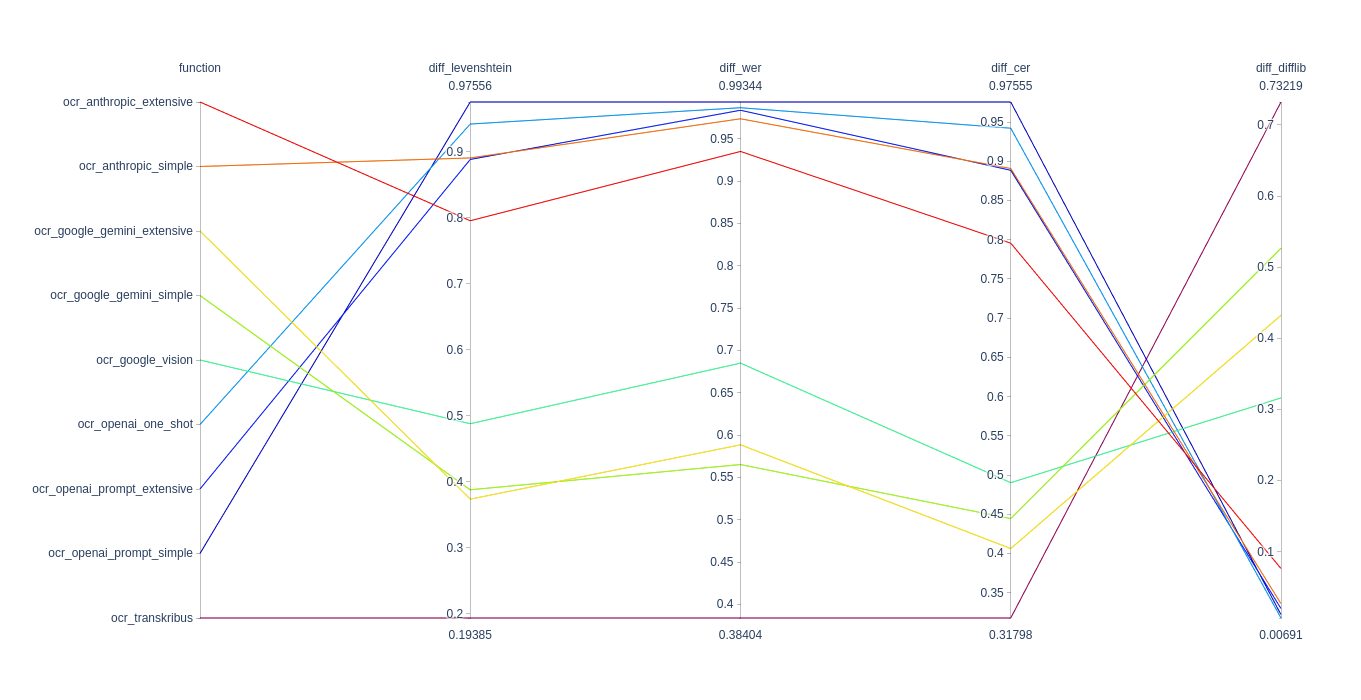

In [53]:
df_avg = df[df["image_id"] == "average"].copy()
function_labels = df_avg["function"].unique()
function_map = {name: i for i, name in enumerate(function_labels)}
df_avg["function_code"] = df_avg["function"].map(function_map)
metric_columns = ["diff_levenshtein", "diff_wer", "diff_cer", "diff_difflib"]
dim_list = [{"label": col, "values": df_avg[col]} for col in metric_columns]
dim_list.insert(
    0,
    {
        "label": "function",
        "values": df_avg["function_code"],
        "tickvals": list(function_map.values()),
        "ticktext": list(function_map.keys()),
    },
)
fig = go.Figure(
    data=go.Parcoords(
        line={
            "color": list(df_avg.index),
            "colorscale": "Rainbow",
        },
        dimensions=dim_list,
    )
)
fig.update_layout(
    height=700,
    font=dict(size=14),
    margin=dict(l=200),
)
fig.write_html(plot_path)
fig.show()

# individual experiments

Here, individual ad-hoc experiments can be performed, with a few examples provided.

In [64]:
# changes this boolean to disable or enable experiments.
enable_individual_experiments = True

In [55]:
if enable_individual_experiments:
    text_ground_truth = read_text("1917-12-28_1")
    text_inferenced = ocr_openai_base(prompt="Apply OCR on this image", image_id="1917-12-28_1")
    print(text_ground_truth[:1000])
    print("------------------------------------------------------------")
    print(text_inferenced[:1000])
    print("------------------------------------------------------------")
    print(diff_all(text_ground_truth, text_inferenced))

Wiener Abendpost
E
1917. — Nr. 296.
Beilage zur Wiener Zeitung.
Freitag, 28. Dezember.
Pränumerations-Preise:
Ganzj. 8 Kronen, halbj. 4 Kronen, viertelj. 3 Kronen, monatl. 80 Heller. Die Zustellungsgebühr beträgt monatlich 40 Heller, — Mit Postversendung Ganzj. 12 Kronen, halbj. 6 Kronen, viertelj. 3 Kronen, monatl. 1 Krone 20 Heller. 
Einzelne Nummern 4 Heller. Redaktion: 1., Bäckerstraße 13 (Telephon Nr. 13.464 und 18.528); Verwaltung: 1. Bäckerstraße 13 (Telephon Nr. 22.543); Druckerei: 1., Bäckerstraße 20 (Telephon Nr. 14.824). Einzelne Nummern 4 Heller.
Die Friedensverhandlungen mit Rußland.
Wien, 28. Dezember.
Das k. k. Telegraphen=Korrespondenz=Bureau meldet
aus Brest-Litowsk vom 27. d. M.:
Die Beratungen der Delegationen der Verbündeten
mit den Vertretern Rußlands über die Spezialfragen
wurden auch im Laufe des heutigen Tages fortgesetzt.
Diese Beratungen sind inzwischen so weit gefördert
worden, daß eine kurze Unterbrechung der
Verhandlungen in Aussicht genommen werden muß,
um

In [56]:
if enable_individual_experiments:
    text_ground_truth = read_text("1917-12-28_1")
    experiment_prompt_one_shot_ground_truth = (
        "Hier ist ein Beispielbild einer historischen Frakturschrift-Zeitung mit seiner korrekten Transkription:"
    )
    experiment_prompt_one_shot_inference = (
        "Anhand der vorrangegangen korrekten Transkription dieses Beispiels, transkripiere jetzt das folgende neue Bild:"
    )
    text_inferenced = ocr_openai_one_shot_base(
        prompt_ground_truth=experiment_prompt_one_shot_ground_truth,
        prompt_inference=experiment_prompt_one_shot_inference,
        image_id_ground_truth="1917-12-28_2",
        image_id_inference="1917-12-28_1",
    )
    print(text_ground_truth[:1000])
    print("------------------------------------------------------------")
    print(text_inferenced[:1000])
    print("------------------------------------------------------------")
    print(diff_all(text_ground_truth, text_inferenced))

Wiener Abendpost
E
1917. — Nr. 296.
Beilage zur Wiener Zeitung.
Freitag, 28. Dezember.
Pränumerations-Preise:
Ganzj. 8 Kronen, halbj. 4 Kronen, viertelj. 3 Kronen, monatl. 80 Heller. Die Zustellungsgebühr beträgt monatlich 40 Heller, — Mit Postversendung Ganzj. 12 Kronen, halbj. 6 Kronen, viertelj. 3 Kronen, monatl. 1 Krone 20 Heller. 
Einzelne Nummern 4 Heller. Redaktion: 1., Bäckerstraße 13 (Telephon Nr. 13.464 und 18.528); Verwaltung: 1. Bäckerstraße 13 (Telephon Nr. 22.543); Druckerei: 1., Bäckerstraße 20 (Telephon Nr. 14.824). Einzelne Nummern 4 Heller.
Die Friedensverhandlungen mit Rußland.
Wien, 28. Dezember.
Das k. k. Telegraphen=Korrespondenz=Bureau meldet
aus Brest-Litowsk vom 27. d. M.:
Die Beratungen der Delegationen der Verbündeten
mit den Vertretern Rußlands über die Spezialfragen
wurden auch im Laufe des heutigen Tages fortgesetzt.
Diese Beratungen sind inzwischen so weit gefördert
worden, daß eine kurze Unterbrechung der
Verhandlungen in Aussicht genommen werden muß,
um

In [57]:
if enable_individual_experiments:
    text_ground_truth = read_text("1917-12-28_1")
    text_inferenced = ocr_google_vision(image_id="1917-12-28_1")
    print(text_ground_truth[:1000])
    print("------------------------------------------------------------")
    print(text_inferenced[:1000])
    print("------------------------------------------------------------")
    print(diff_all(text_ground_truth, text_inferenced))

Wiener Abendpost
E
1917. — Nr. 296.
Beilage zur Wiener Zeitung.
Freitag, 28. Dezember.
Pränumerations-Preise:
Ganzj. 8 Kronen, halbj. 4 Kronen, viertelj. 3 Kronen, monatl. 80 Heller. Die Zustellungsgebühr beträgt monatlich 40 Heller, — Mit Postversendung Ganzj. 12 Kronen, halbj. 6 Kronen, viertelj. 3 Kronen, monatl. 1 Krone 20 Heller. 
Einzelne Nummern 4 Heller. Redaktion: 1., Bäckerstraße 13 (Telephon Nr. 13.464 und 18.528); Verwaltung: 1. Bäckerstraße 13 (Telephon Nr. 22.543); Druckerei: 1., Bäckerstraße 20 (Telephon Nr. 14.824). Einzelne Nummern 4 Heller.
Die Friedensverhandlungen mit Rußland.
Wien, 28. Dezember.
Das k. k. Telegraphen=Korrespondenz=Bureau meldet
aus Brest-Litowsk vom 27. d. M.:
Die Beratungen der Delegationen der Verbündeten
mit den Vertretern Rußlands über die Spezialfragen
wurden auch im Laufe des heutigen Tages fortgesetzt.
Diese Beratungen sind inzwischen so weit gefördert
worden, daß eine kurze Unterbrechung der
Verhandlungen in Aussicht genommen werden muß,
um